## Initialization

In [50]:
# Imports: 
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.sampling import DiscreteAliasUrn
from scipy.stats import chi
from scipy.stats import geom, kstest
import time
np.random.seed(123)

## 1) Geometric distribution
- Choose a value for p and sample 10.000 samples from geometric distribution.

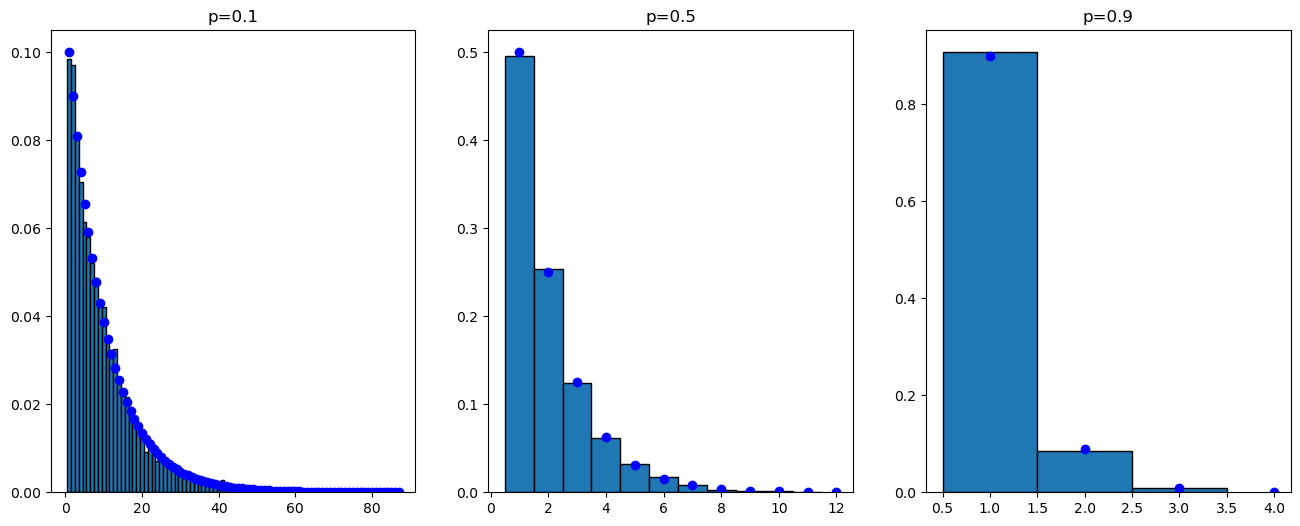

In [51]:
# chosen value for p is
p = [0.1, 0.5, 0.9]
N = 10000
def GeoRandVar(p,N):
    return np.random.geometric(p, N)

figure, axis = plt.subplots(1, 3,figsize=(16, 6)) 

for i in range(len(p)):
    Geo_samples = GeoRandVar(p[i],N)

    # plot sample 
    axis[i].hist(Geo_samples, bins=np.arange(1, max(Geo_samples) + 1) - 0.5,density=True,edgecolor='black')
    axis[i].set_title(f'p={p[i]}')

    #plot true values
    x = np.arange(1, max(Geo_samples) + 1)
    pmf = geom.pmf(x, p[i])
    axis[i].plot(x, pmf, 'bo')

plt.show() 


## 6-point Distribution: 
- Simulate the 6-point distribution using the crude, rejection and alias Method

In [52]:
# Define the discrete distribution
X = np.array([1, 2, 3, 4, 5, 6])
P = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])
N = 10000

## Direct (Crude) Method

In [53]:
start_time = time.time()

def DirectMethod(X,P,N):
    U = np.random.uniform(0, 1, N)

    Sample_direct = X[np.searchsorted(np.cumsum(P), U)]
    
    return  Sample_direct 

direct_samples = DirectMethod(X,P,N)

Direct_time = time.time() - start_time


## 6-point distribution: Rejection Method 

In [54]:
start_time = time.time()


def RejectionMethod(X,P,N):
    p_max = max(P)

    rejection_samples = []
    while len(rejection_samples) < N:
        u = np.random.uniform(0, 1)
        x = np.random.choice(X)
        if u < P[x-1] / p_max:
            rejection_samples.append(x)
    
    return rejection_samples

rejection_samples = RejectionMethod(X,P,N)

rejection_time = time.time() - start_time

## 6-point distribution: Alias Method 

In [55]:
start_time = time.time()

def create_alias_table(probabilities):
    n = len(probabilities)
    scaled_probs = np.array(probabilities) * n
    alias = np.zeros(n, dtype=int)
    prob = np.zeros(n)
    small = []
    large = []
    
    for i, p in enumerate(scaled_probs):
        if p < 1:
            small.append(i)
        else:
            large.append(i)
    
    while small and large:
        l = small.pop()
        g = large.pop()
        prob[l] = scaled_probs[l]
        alias[l] = g
        scaled_probs[g] = scaled_probs[g] - (1 - scaled_probs[l])
        if scaled_probs[g] < 1:
            small.append(g)
        else:
            large.append(g)
    
    while large:
        g = large.pop()
        prob[g] = 1
    while small:
        l = small.pop()
        prob[l] = 1
    
    return prob, alias


def AliasMethod(X,P,N):
    # Creating alias tables
    prob, alias = create_alias_table(P)

    alias_samples = []
    for _ in range(N):
        i = np.random.randint(0, len(P))
        u = np.random.uniform(0, 1)
        if u < prob[i]:
            alias_samples.append(X[i])
        else:
            alias_samples.append(X[alias[i]])

    alias_samples = np.array(alias_samples)
    return alias_samples

alias_samples =AliasMethod(X,P,N)

# Time it takes to compute the alias samples
alias_time = time.time() - start_time

## Visualization

Text(0.5, 1.0, 'Alias Method')

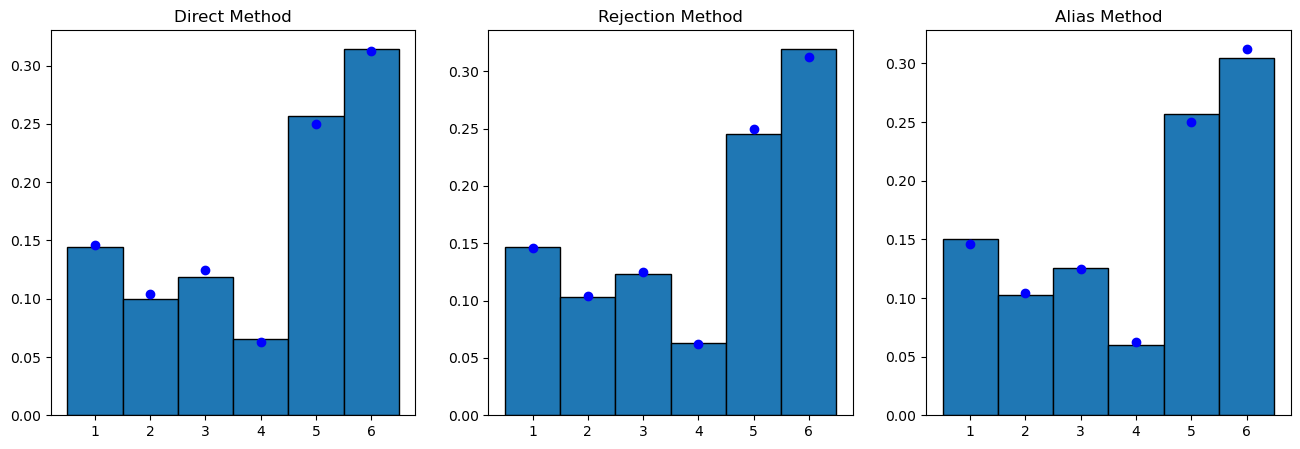

In [56]:
figure, axis = plt.subplots(1, 3,figsize=(16, 5)) 

axis[0].hist(direct_samples, bins=np.arange(1, 8) - 0.5, density=True,edgecolor='black')
axis[0].plot(X,P,'bo')
axis[0].set_title('Direct Method')

axis[1].hist(rejection_samples, bins=np.arange(1, 8) - 0.5, density=True,edgecolor='black')
axis[1].plot(X,P,'bo')
axis[1].set_title('Rejection Method')

axis[2].hist(alias_samples, bins=np.arange(1, 8)-0.5, density=True,edgecolor='black')
axis[2].plot(X,P,'bo')
axis[2].set_title('Alias Method')


## Comparing Methods
- Compare the three different methods using adequate criteria and discuss results

In [57]:
import scipy.stats as stats

def comparer(samples, expected_prob):
    alpha = 0.05  # Significance level
    observed_counts = np.bincount(samples)[1:]
    n_samples = len(samples)
    expected_counts = expected_prob * n_samples
    df = len(expected_prob) - 1  # Degrees of freedom
    chi2_stat = np.sum((observed_counts - expected_counts)**2 / expected_counts)
    p_value = 1 - stats.chi2.cdf(chi2_stat, df)
    critical_value = stats.chi2.ppf(1 - alpha, df)
    return chi2_stat, p_value, critical_value

direct_chi2 , direct_p_value, direct_critical_value = comparer(direct_samples, P)
rejection_chi2, rejection_p_value, rejection_critical_value = comparer(rejection_samples, P)
alias_chi2, alias_p_value, alias_critical_value = comparer(alias_samples, P)

# Print comparison results
print(f"Method\t\tTime (s)\tChi-Square Statistic\tp-Value\t\tCritical Value")
print(f"Direct\t\t{Direct_time:.4f}\t\t{direct_chi2:.4f}\t\t\t{direct_p_value:.4f}\t\t{direct_critical_value:.4f}")
print(f"Rejection\t{rejection_time:.4f}\t\t{rejection_chi2:.4f}\t\t\t{rejection_p_value:.4f}\t\t{rejection_critical_value:.4f}")
print(f"Alias\t\t{alias_time:.4f}\t\t{alias_chi2:.4f}\t\t\t{alias_p_value:.4f}\t\t{rejection_critical_value:.4f}")

Method		Time (s)	Chi-Square Statistic	p-Value		Critical Value
Direct		0.0009		8.1019			0.1507		11.0705
Rejection	0.2248		3.0422			0.6935		11.0705
Alias		0.0597		6.0245			0.3038		11.0705
